## Functions

In [3]:
import pandas as pd
import numpy as np
import surprise as sp
from surprise.model_selection import train_test_split
from surprise.model_selection import GridSearchCV
from surprise.model_selection import cross_validate
from sklearn.cluster import KMeans
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib notebook

In [4]:
def prep_data(sheet):
    dfm = pd.read_excel('TestData.xlsx', sheet_name = sheet)
    df_flat = dfm.melt(id_vars=['Req'])
    df_flat = df_flat.dropna()
    df_flat.columns = ['Req','Candidate','Score']
    df_flat = df_flat.dropna()
    df_new = df_flat[['Candidate','Req','Score']]
    reader = sp.Reader(rating_scale=(0, 1))
    data = sp.Dataset.load_from_df(df_new, reader)
    trainset, testset = train_test_split(data, test_size=0.25)
    
    return trainset, testset, data

In [14]:
def tuning(data):
    param_grid = {'n_factors': [2,3,4], 'n_epochs': [100, 1000, 1500], 'lr_all': [0.001, 0.003, 0.010],
              'reg_all': [0.03, 0.10, 0.30]}
    gs = GridSearchCV(sp.SVD, param_grid, measures=['rmse', 'mae'], cv=3)
    gs.fit(data)
    model = gs.best_estimator['rmse']
    print('RMSE of best model:',gs.best_score['rmse'])
    print('Parameters of best model:',gs.best_params['rmse'])
    cross_validate(model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
    
    best_params = gs.best_params['rmse']
    return model, best_params

In [28]:
def CF(model, trainset, testset, n_factors):
    
    # Train the model on the trainset, and predict ratings for the testset
    model.fit(trainset)
    predictions = model.test(testset)
    sp.accuracy.rmse(predictions) # Then compute RMSE
    print(pd.DataFrame(predictions).head()) # show some predictions
    # model.predict('CA30','JR20') # now, let's test accuracy of predictions on empty cells
    
    # create a df with all the factors (features), in correct order of the reqs
    req_list = [trainset.to_raw_iid(i) for i in range(0,20)]
    factors_df = pd.DataFrame({'f'+str(i):model.qi[:,i] for i in range(0,n_factors)}) 
    factors_df.index = req_list
    factors_df.sort_index(inplace=True)
    
    return factors_df

In [7]:
def cluster(factors_df, n_clusters):
    kmeans = KMeans(n_clusters=n_clusters, random_state=99).fit(factors_df)
    clustered_df = factors_df.copy() # don't change the original df, but create a new one
    clustered_df['Cluster'] = kmeans.labels_
    average_score = kmeans.inertia_/len(factors_df)
    return clustered_df, average_score

## Tune & Run

In [8]:
trainset, testset, data = prep_data('Matrix5') # load the data from excel and prepare it

In [16]:
model, best_params = tuning(data) # find the best hyperparameters and get the model with these parameters

RMSE of best model: 0.44119926385648806
Parameters of best model: {'n_factors': 3, 'n_epochs': 1000, 'lr_all': 0.003, 'reg_all': 0.1}
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.4376  0.4234  0.4024  0.4097  0.4329  0.4212  0.0134  
MAE (testset)     0.3539  0.3450  0.3058  0.3136  0.3406  0.3318  0.0187  
Fit time          0.27    0.27    0.26    0.26    0.26    0.26    0.01    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    


In [19]:
n_factors = best_params['n_factors']
factors_df = CF(model, trainset, testset, n_factors) # Apply collaborative filtering model to extract features of the reqs

RMSE: 0.4305
    uid   iid  r_ui       est                    details
0  CA03  JR05   1.0  0.475071  {'was_impossible': False}
1  CA14  JR09   0.0  0.597194  {'was_impossible': False}
2  CA04  JR17   0.0  0.120454  {'was_impossible': False}
3  CA08  JR17   0.0  0.044157  {'was_impossible': False}
4  CA12  JR08   0.0  0.293318  {'was_impossible': False}


In [20]:
factors_df.head(10)

,f0,f1,f2
JR01,0.418293,-0.324282,0.078071
JR02,0.353298,-0.538345,-0.057192
JR03,0.079476,-0.496711,-0.058932
JR04,0.348266,-0.299642,-0.116256
JR05,0.152701,-0.450069,-0.013337
JR06,-0.356670,-0.048485,-0.048078
JR07,-0.325228,0.046826,-0.335077
JR08,-0.066346,0.042961,-0.231159
JR09,-0.420479,0.000667,-0.153011
JR10,-0.329952,0.030380,-0.415367


In [22]:
# find the optimal number of clusters
def clusters_chart(factors_df, max_clusters=10):
    cluster_results = np.zeros([max_clusters, 2])
    for clusters in range(1,max_clusters+1):
        _, average_score = cluster(factors_df, clusters) # Cluster the reqs based on discovered features
        cluster_results[clusters-1,0] = clusters
        cluster_results[clusters-1,1] = average_score
    plt.figure()
    plt.plot(cluster_results[:,0],cluster_results[:,1])
    return cluster_results

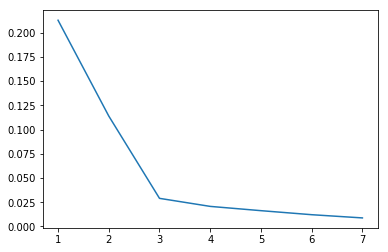

In [23]:
ar = clusters_chart(factors_df, 7)

In [24]:
# now, after we manually select the number of clusters by looking at the chart, we can re-apply clustering
clustered_factors, _ = cluster(factors_df, 3)

## Examine Results

In [25]:
clustered_factors.Cluster.value_counts()

2    9
1    6
0    5
Name: Cluster, dtype: int64

In [26]:
clustered_factors

,f0,f1,f2,Cluster
JR01,0.418293,-0.324282,0.078071,0
JR02,0.353298,-0.538345,-0.057192,0
JR03,0.079476,-0.496711,-0.058932,0
JR04,0.348266,-0.299642,-0.116256,0
JR05,0.152701,-0.450069,-0.013337,0
JR06,-0.356670,-0.048485,-0.048078,2
JR07,-0.325228,0.046826,-0.335077,2
JR08,-0.066346,0.042961,-0.231159,2
JR09,-0.420479,0.000667,-0.153011,2
JR10,-0.329952,0.030380,-0.415367,2


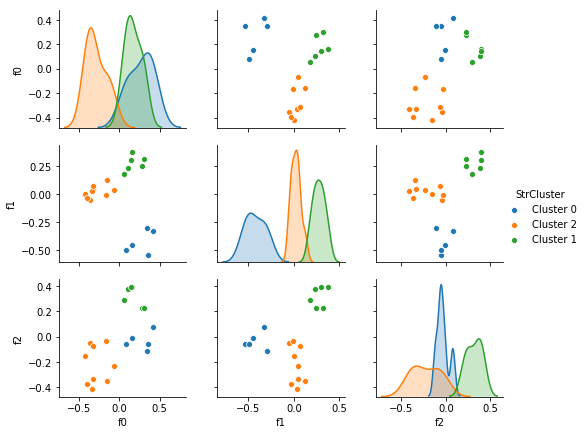

In [27]:
# create pair plot
plot_data = clustered_factors.copy()
plot_data['StrCluster'] = 'Cluster ' + plot_data.Cluster.astype(str) # convert cluster column to string
plot_data.drop(columns = ['Cluster'], inplace = True) # remove the numeric cluster column
sns.pairplot(plot_data, hue = 'StrCluster'); # show pair plot
fig = plt.gcf()
fig.set_size_inches(8, 6)